In [35]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd

In [155]:
#read CSV data and convert to Pandas Dataframe for column exctraction, then check type.
#File M is the matrix of x and y from fit data in Matlab
g2_data = pd.read_csv("C:/Users/maris/Documents/QC_Modeling_Bayesian/M_tab.csv", usecols=['photon_spacing', 'g2'])
# print(g2_data.head())
time_array = np.array(g2_data['photon_spacing'])
g2_array = np.array(g2_data['g2'])

Text(0, 0.5, 'MatLab Fit g(^2) Function')

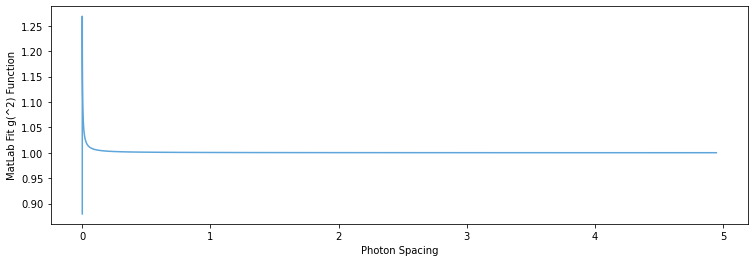

In [156]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")
#Arbitary x-label to match Andrews 20201031 MatLab axes
plt.xlabel("Photon Spacing")
plt.ylabel("MatLab Fit g(^2) Function")
#plt.ylim(0.8, 2.2)

Text(0, 0.5, 'MatLab Fit g(^2) Function')

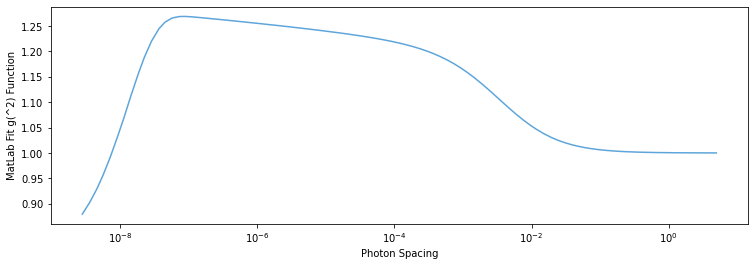

In [157]:
# Defining our Data into tensor array for TFP from Pd.Array type
# # Visualizing the Results as a check 
plt.figure(figsize=(12.5, 4))
plt.plot(time_array, g2_array, color="#5DA5DA")

plt.xscale('log')
plt.xlabel("Photon Spacing")
plt.ylabel("MatLab Fit g(^2) Function")
#plt.ylim(0.8, 2.2)

In [158]:
# set random seed for reproducibility
np.random.seed(12345)
x = time_array;

# Parameters for fit
A = 0.31
B = 5.8e-1
m = 0.1
Td = 3.6e-3
k = 2.7e-1
Ta = 4.00e-08

fit = lambda A, B, m, Td, k, Ta , x: 1+A*((1-B*x**(m))*1/(1+(x/Td)))-k*np.exp(-x/Ta)

model = fit(x=x, A= A, B= B, m= m, Td= Td, k= k, Ta =Ta)

# add noise to the data points
noise = np.random.normal(size=len(x)) * .02 
model_noise = model + noise 

# Determine absolute error between Model and g2_from_qutip
model_error = np.abs(model - g2_array)

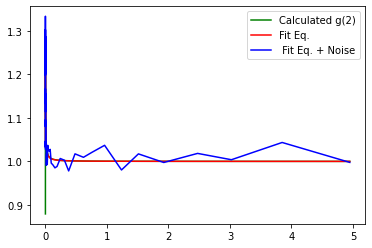

In [147]:
plt.plot(time_array, g2_array, color='g', label="MatLab Fit g(^2) Function")
plt.plot(time_array, model, color='r', label="Fit Eq. from Above")
plt.plot(time_array, model_noise, color='b', label=" Fit Eq. + Random Noise")
plt.legend();

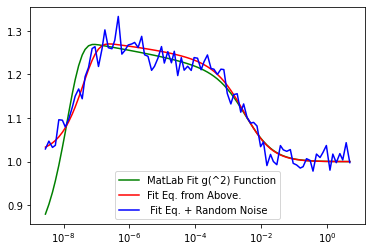

In [159]:
plt.plot(time_array, g2_array, color='g', label="MatLab Fit g(^2) Function")
plt.plot(time_array, model, color='r', label="Fit Eq. from Above.")
plt.plot(time_array, model_noise, color='b', label=" Fit Eq. + Random Noise")
plt.xscale('log')
plt.legend();

In [160]:
with pm.Model() as model3:
    
    #To start, set all parameters to uniform, continuous distributions
    A = pm.Uniform('A', 0.0, 1.0, testval = 0.31)
    B =  pm.Uniform('B', 0.0, 1.0, testval = 5.8e-1)
    m = pm.Uniform('m', 0.0, 1.0, testval = 0.1)
    Td = pm.Uniform('Td', 0.0, 1.0, testval = 3.6e-3)
    k = pm.Uniform('k', 0.0, 1.0, testval = 2.7e-1)
    Ta = pm.Uniform('Ta', 0.0, 1.0, testval = 4.00e-08)

    fit=pm.Deterministic('fit', (1+A*((1-B*x**(m))*1/(1+(x/Td)))-k*np.exp(-x/Ta)))
    
    #mu deterministic parameters
    y =pm.Normal('y', mu=fit, tau=1.0/model_error**2, observed=g2_array)

In [161]:
with model3:
    start=pm.find_MAP()
    trace=pm.sample(20000)

logp = 440.41, ||grad|| = 13.025: 100%|██████████████████████████████████████████████| 77/77 [00:00<00:00, 2088.27it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Ta, k, Td, m, B, A]
Sampling 4 chains, 111 divergences: 100%|█████████████████████████████████████| 82000/82000 [31:36<00:00, 43.24draws/s]
There were 111 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.619055474713325, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


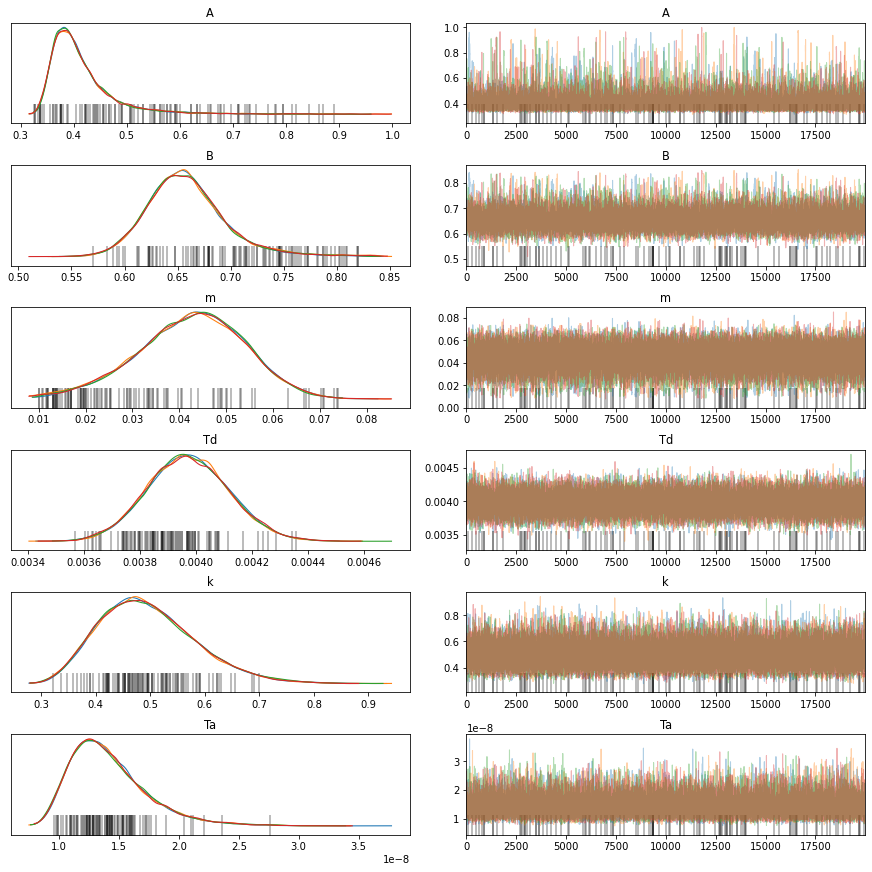

In [162]:
with model3:
    az.plot_trace(trace, var_names=["A","B","m","Td","k","Ta"])

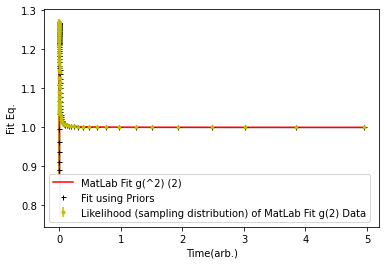

In [165]:
# extract and plot results Linear plot
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

plt.plot(time_array, g2_array,'r', label='MatLab Fit g(^2) (2)')
plt.errorbar(time_array, model, yerr=model_error, color='y', marker='.', ls='None', label='Likelihood (sampling distribution) of MatLab Fit g(2) Data')
plt.plot(time_array, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit using Priors')
plt.fill_between(time_array, y_min, y_max, color='0.5', alpha=0.5)
plt.legend();
plt.ylabel("Fit Eq.");
plt.xlabel("Time(arb.)");

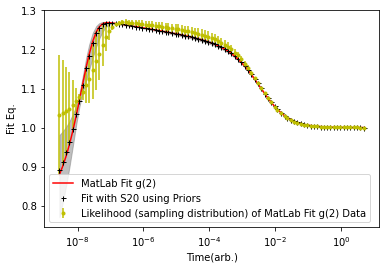

In [166]:
# extract and plot results Log Plot
y_min = np.percentile(trace.fit, 2.5, axis=0)
y_max = np.percentile(trace.fit, 97.5, axis=0)
y_fit = np.percentile(trace.fit, 50, axis=0)

plt.xscale('log')

plt.plot(time_array, g2_array,'r', label='MatLab Fit g(2)')
plt.errorbar(time_array, model, yerr=model_error, color='y', marker='.', ls='None', label='Likelihood (sampling distribution) of MatLab Fit g(2) Data')
plt.plot(time_array, y_fit,'k', marker='+', ls='None', ms=5, mew=1, label='Fit with S20 using Priors')
plt.fill_between(time_array, y_min, y_max, color='0.5', alpha=0.5)
plt.legend();
plt.ylabel("Fit Eq.");
plt.xlabel("Time(arb.)");